### Monitoring of the water extent of Lake Neusiedl and the Lacken:
#### Train and Evaluation

In [1]:

#import sys
from google.colab import drive
#drive.mount('/content/drive')
#sys.path.append('/content/drive/MyDrive/IntProject')

ModuleNotFoundError: No module named 'google.colab'

In [2]:

import sys
# #
# del sys.modules['data_func']
# del sys.modules['utils']
# del sys.modules['model']


In [3]:
# pip install yeoda

In [4]:
# pip install tifftools

In [5]:
import torch
import copy
import numpy as np
from data_func import merge_files_and_split, ImageDataset, make_list, visualize_augmentations
from model import DownSample, DoubleConv, OutConv, UpSample, UNet, DecoderBlockv2,UNetFT
#from model2 import *
from utils import *
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch import optim, nn
import cv2
import time
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.optim import Adam
from torch import permute
from torch import nan_to_num
from torch.nn import BCEWithLogitsLoss
from torchvision.transforms import ToTensor
import rasterio
from torch import nn
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
from torch.nn import functional as F

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
import albumentations as A

from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
# pip install tqdm

In [7]:
# pip install torchvision

### Data Preparation & Augmentation

In [8]:
train_batch_size = 4
val_batch_size = 4
test_batch_size = 1

In [9]:
train_transform = A.Compose([

    A.Resize(256, 256),
    A.RandomResizedCrop(256, 256, scale=(0.3, 0.5), p=0.5),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
], )

test_transform = A.Compose([

    A.Resize(256, 256),

], )



In [10]:

run_colab = True
if run_colab:
    train_set = ImageDataset('./drive/MyDrive/IntProject/train/', './drive/MyDrive/IntProject/train_mask',
                             './drive/MyDrive/IntProject/train_mask_lacken',
                             train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./drive/MyDrive/IntProject/val/', './drive/MyDrive/IntProject/val_mask', './drive/MyDrive/IntProject/val_mask_lacken',
                           train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./drive/MyDrive/IntProject/test/', './drive/MyDrive/IntProject/test_mask',
                             './drive/MyDrive/IntProject/test_mask_lacken', test_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = './drive/MyDrive/IntProject/model_results3.txt'
    model_file = './drive/MyDrive/IntProject/model3.pt'
else:
    train_set = ImageDataset('./train/', './train_mask', './train_mask_lacken', train_transform)
    trainloader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=1)
    val_set = ImageDataset('./val/', './val_mask', './val_mask_lacken', train_transform)
    valloader = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle=True, num_workers=1)
    test_set = ImageDataset('./test/', './test_mask', './test_mask_lacken', test_transform)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
    dict_file = './model_results3.txt'
    model_file = './model3.pt'


FileNotFoundError: [Errno 2] No such file or directory: './drive/MyDrive/IntProject/train/'

In [11]:
dataset_sizes = [len(train_set), len(val_set), len(test_set)]
labels = ['train', 'val', 'test']

plt.bar(labels, dataset_sizes)
plt.show()

NameError: name 'train_set' is not defined

In [12]:
visualize_augmentations(train_set, idx=1, samples=5)

NameError: name 'train_set' is not defined


#### Train & Evaluate

In [ ]:
epochs = 50
pretrained = True
pretrained = True
model = UNetFT(1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)
grad_scaler = torch.cuda.amp.GradScaler()
criterion = nn.BCEWithLogitsLoss()
global_step = 0

/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_10007/2287859990.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler()
/opt/miniconda3/envs/IntProject/lib/python3.8/site-packages/torch/amp/

In [ ]:
train_evaluate(model, epochs, trainloader, valloader, optimizer, criterion, grad_scaler, scheduler, dict_file,
               model_file, best_dice=0, patience=10)

  2%|▏         | 1/50 [00:30<25:09, 30.80s/it]

 
 Epoch: 1 
TRAIN FUll: Train Loss: 1.5594 | Train DICE Coeff: 0.0667  | Train IoU Coeff: 0.0335|  | Train Accuracy: 81.79 
TRAIN LACKENS: Train DICE Coeff: 0.0017  | Train IoU Coeff: 0.0010|  | Train Accuracy: 81.86 
VAL FULL: Val Loss: 1.5327 | Val DICE Coeff: 0.0013 | Val IoU Coeff: 0.0003| Val Accuracy: 98.52| 
VAL LACKENS: Val DICE Coeff: 0.0867 | Val IoU Coeff: 0.0135| Val Accuracy: 99.97| 


  4%|▍         | 2/50 [01:01<24:36, 30.76s/it]

 
 Epoch: 2 
TRAIN FUll: Train Loss: 1.4586 | Train DICE Coeff: 0.1004  | Train IoU Coeff: 0.0631|  | Train Accuracy: 95.47 
TRAIN LACKENS: Train DICE Coeff: 0.0015  | Train IoU Coeff: 0.0012|  | Train Accuracy: 95.71 
VAL FULL: Val Loss: 1.4481 | Val DICE Coeff: 0.0012 | Val IoU Coeff: 0.0003| Val Accuracy: 98.48| 
VAL LACKENS: Val DICE Coeff: 0.0645 | Val IoU Coeff: 0.0152| Val Accuracy: 99.98| 


  6%|▌         | 3/50 [01:32<24:18, 31.02s/it]

 
 Epoch: 3 
TRAIN FUll: Train Loss: 1.4000 | Train DICE Coeff: 0.0186  | Train IoU Coeff: 0.0102|  | Train Accuracy: 97.50 
TRAIN LACKENS: Train DICE Coeff: 0.0009  | Train IoU Coeff: 0.0002|  | Train Accuracy: 98.27 
VAL FULL: Val Loss: 1.4044 | Val DICE Coeff: 0.0011 | Val IoU Coeff: 0.0002| Val Accuracy: 98.40| 
VAL LACKENS: Val DICE Coeff: 0.0796 | Val IoU Coeff: 0.0103| Val Accuracy: 99.96| 


  8%|▊         | 4/50 [02:03<23:45, 31.00s/it]

 
 Epoch: 4 
TRAIN FUll: Train Loss: 1.3498 | Train DICE Coeff: 0.0475  | Train IoU Coeff: 0.0420|  | Train Accuracy: 98.16 
TRAIN LACKENS: Train DICE Coeff: 0.0023  | Train IoU Coeff: 0.0005|  | Train Accuracy: 99.18 
VAL FULL: Val Loss: 1.6012 | Val DICE Coeff: 0.0256 | Val IoU Coeff: 0.0134| Val Accuracy: 75.54| 
VAL LACKENS: Val DICE Coeff: 0.0006 | Val IoU Coeff: 0.0002| Val Accuracy: 75.78| 


 10%|█         | 5/50 [03:23<36:31, 48.69s/it]

 
 Epoch: 5 
TRAIN FUll: Train Loss: 1.3247 | Train DICE Coeff: 0.2097  | Train IoU Coeff: 0.1734|  | Train Accuracy: 99.13 
TRAIN LACKENS: Train DICE Coeff: 0.0099  | Train IoU Coeff: 0.0056|  | Train Accuracy: 99.54 
VAL FULL: Val Loss: 1.8815 | Val DICE Coeff: 0.0292 | Val IoU Coeff: 0.0158| Val Accuracy: 15.45| 
VAL LACKENS: Val DICE Coeff: 0.0006 | Val IoU Coeff: 0.0003| Val Accuracy: 14.12| 


 12%|█▏        | 6/50 [03:54<31:12, 42.57s/it]

 
 Epoch: 6 
TRAIN FUll: Train Loss: 1.2959 | Train DICE Coeff: 0.3979  | Train IoU Coeff: 0.3253|  | Train Accuracy: 99.17 
TRAIN LACKENS: Train DICE Coeff: 0.0219  | Train IoU Coeff: 0.0161|  | Train Accuracy: 99.12 
VAL FULL: Val Loss: 2.0488 | Val DICE Coeff: 0.0147 | Val IoU Coeff: 0.0076| Val Accuracy: 32.97| 
VAL LACKENS: Val DICE Coeff: 0.0003 | Val IoU Coeff: 0.0001| Val Accuracy: 33.01| 


 14%|█▍        | 7/50 [04:25<27:40, 38.62s/it]

 
 Epoch: 7 
TRAIN FUll: Train Loss: 1.2587 | Train DICE Coeff: 0.4701  | Train IoU Coeff: 0.4142|  | Train Accuracy: 98.89 
TRAIN LACKENS: Train DICE Coeff: 0.0282  | Train IoU Coeff: 0.0057|  | Train Accuracy: 98.50 
VAL FULL: Val Loss: 2.4900 | Val DICE Coeff: 0.0119 | Val IoU Coeff: 0.0052| Val Accuracy: 23.51| 
VAL LACKENS: Val DICE Coeff: 0.0003 | Val IoU Coeff: 0.0001| Val Accuracy: 23.29| 


 16%|█▌        | 8/50 [04:55<25:14, 36.06s/it]

 
 Epoch: 8 
TRAIN FUll: Train Loss: 1.2391 | Train DICE Coeff: 0.5561  | Train IoU Coeff: 0.4135|  | Train Accuracy: 98.77 
TRAIN LACKENS: Train DICE Coeff: 0.0337  | Train IoU Coeff: 0.0120|  | Train Accuracy: 98.10 
VAL FULL: Val Loss: 2.7703 | Val DICE Coeff: 0.0202 | Val IoU Coeff: 0.0094| Val Accuracy: 30.40| 
VAL LACKENS: Val DICE Coeff: 0.0003 | Val IoU Coeff: 0.0002| Val Accuracy: 30.11| 


 18%|█▊        | 9/50 [11:18<1:38:48, 144.59s/it]

 
 Epoch: 9 
TRAIN FUll: Train Loss: 1.2326 | Train DICE Coeff: 0.4786  | Train IoU Coeff: 0.3412|  | Train Accuracy: 98.58 
TRAIN LACKENS: Train DICE Coeff: 0.0260  | Train IoU Coeff: 0.0121|  | Train Accuracy: 97.95 
VAL FULL: Val Loss: 3.6983 | Val DICE Coeff: 0.0329 | Val IoU Coeff: 0.0152| Val Accuracy: 33.95| 
VAL LACKENS: Val DICE Coeff: 0.0004 | Val IoU Coeff: 0.0002| Val Accuracy: 33.07| 


 20%|██        | 10/50 [11:50<1:13:06, 109.67s/it]

 
 Epoch: 10 
TRAIN FUll: Train Loss: 1.2114 | Train DICE Coeff: 0.5469  | Train IoU Coeff: 0.3993|  | Train Accuracy: 98.72 
TRAIN LACKENS: Train DICE Coeff: 0.0279  | Train IoU Coeff: 0.0106|  | Train Accuracy: 98.06 
VAL FULL: Val Loss: 3.9566 | Val DICE Coeff: 0.1394 | Val IoU Coeff: 0.0201| Val Accuracy: 50.78| 
VAL LACKENS: Val DICE Coeff: 0.0010 | Val IoU Coeff: 0.0003| Val Accuracy: 49.92| 


 22%|██▏       | 11/50 [12:20<55:33, 85.47s/it]   

 
 Epoch: 11 
TRAIN FUll: Train Loss: 1.2041 | Train DICE Coeff: 0.5277  | Train IoU Coeff: 0.3789|  | Train Accuracy: 98.87 
TRAIN LACKENS: Train DICE Coeff: 0.0243  | Train IoU Coeff: 0.0123|  | Train Accuracy: 98.27 
VAL FULL: Val Loss: 2.1644 | Val DICE Coeff: 0.0877 | Val IoU Coeff: 0.0156| Val Accuracy: 71.07| 
VAL LACKENS: Val DICE Coeff: 0.0007 | Val IoU Coeff: 0.0002| Val Accuracy: 71.14| 


 24%|██▍       | 12/50 [12:51<43:36, 68.85s/it]

 
 Epoch: 12 
TRAIN FUll: Train Loss: 1.1734 | Train DICE Coeff: 0.5909  | Train IoU Coeff: 0.4873|  | Train Accuracy: 99.17 
TRAIN LACKENS: Train DICE Coeff: 0.0355  | Train IoU Coeff: 0.0086|  | Train Accuracy: 98.54 
VAL FULL: Val Loss: 1.2890 | Val DICE Coeff: 0.3220 | Val IoU Coeff: 0.0490| Val Accuracy: 93.03| 
VAL LACKENS: Val DICE Coeff: 0.0023 | Val IoU Coeff: 0.0005| Val Accuracy: 93.27| 


 26%|██▌       | 13/50 [13:22<35:17, 57.24s/it]

 
 Epoch: 13 
TRAIN FUll: Train Loss: 1.1680 | Train DICE Coeff: 0.5464  | Train IoU Coeff: 0.3720|  | Train Accuracy: 98.65 
TRAIN LACKENS: Train DICE Coeff: 0.0341  | Train IoU Coeff: 0.0112|  | Train Accuracy: 98.11 
VAL FULL: Val Loss: 1.1546 | Val DICE Coeff: 0.3182 | Val IoU Coeff: 0.3766| Val Accuracy: 99.16| 
VAL LACKENS: Val DICE Coeff: 0.0085 | Val IoU Coeff: 0.0011| Val Accuracy: 98.98| 


 28%|██▊       | 14/50 [13:52<29:31, 49.20s/it]

 
 Epoch: 14 
TRAIN FUll: Train Loss: 1.1404 | Train DICE Coeff: 0.6261  | Train IoU Coeff: 0.4605|  | Train Accuracy: 98.90 
TRAIN LACKENS: Train DICE Coeff: 0.0267  | Train IoU Coeff: 0.0139|  | Train Accuracy: 98.14 
VAL FULL: Val Loss: 1.1601 | Val DICE Coeff: 0.4796 | Val IoU Coeff: 0.1871| Val Accuracy: 98.14| 
VAL LACKENS: Val DICE Coeff: 0.0025 | Val IoU Coeff: 0.0007| Val Accuracy: 98.29| 


 30%|███       | 15/50 [14:23<25:25, 43.57s/it]

 
 Epoch: 15 
TRAIN FUll: Train Loss: 1.1354 | Train DICE Coeff: 0.5836  | Train IoU Coeff: 0.4174|  | Train Accuracy: 98.82 
TRAIN LACKENS: Train DICE Coeff: 0.0217  | Train IoU Coeff: 0.0116|  | Train Accuracy: 98.10 
VAL FULL: Val Loss: 1.1289 | Val DICE Coeff: 0.4577 | Val IoU Coeff: 0.2930| Val Accuracy: 97.82| 
VAL LACKENS: Val DICE Coeff: 0.0054 | Val IoU Coeff: 0.0025| Val Accuracy: 96.98| 


 32%|███▏      | 16/50 [14:54<22:29, 39.69s/it]

 
 Epoch: 16 
TRAIN FUll: Train Loss: 1.1348 | Train DICE Coeff: 0.5185  | Train IoU Coeff: 0.3833|  | Train Accuracy: 98.81 
TRAIN LACKENS: Train DICE Coeff: 0.0330  | Train IoU Coeff: 0.0195|  | Train Accuracy: 98.26 
VAL FULL: Val Loss: 1.1167 | Val DICE Coeff: 0.4692 | Val IoU Coeff: 0.2891| Val Accuracy: 97.05| 
VAL LACKENS: Val DICE Coeff: 0.0037 | Val IoU Coeff: 0.0012| Val Accuracy: 95.88| 


 34%|███▍      | 17/50 [19:09<57:34, 104.67s/it]

 
 Epoch: 17 
TRAIN FUll: Train Loss: 1.1156 | Train DICE Coeff: 0.5525  | Train IoU Coeff: 0.4137|  | Train Accuracy: 98.96 
TRAIN LACKENS: Train DICE Coeff: 0.0311  | Train IoU Coeff: 0.0245|  | Train Accuracy: 98.45 
VAL FULL: Val Loss: 1.0755 | Val DICE Coeff: 0.5401 | Val IoU Coeff: 0.4376| Val Accuracy: 98.71| 
VAL LACKENS: Val DICE Coeff: 0.0031 | Val IoU Coeff: 0.0012| Val Accuracy: 97.86| 


 36%|███▌      | 18/50 [19:40<43:56, 82.39s/it] 

 
 Epoch: 18 
TRAIN FUll: Train Loss: 1.0920 | Train DICE Coeff: 0.6142  | Train IoU Coeff: 0.4782|  | Train Accuracy: 99.09 
TRAIN LACKENS: Train DICE Coeff: 0.0425  | Train IoU Coeff: 0.0195|  | Train Accuracy: 98.47 
VAL FULL: Val Loss: 1.0694 | Val DICE Coeff: 0.6442 | Val IoU Coeff: 0.4904| Val Accuracy: 98.96| 
VAL LACKENS: Val DICE Coeff: 0.0035 | Val IoU Coeff: 0.0017| Val Accuracy: 98.00| 


 38%|███▊      | 19/50 [20:10<34:29, 66.77s/it]

 
 Epoch: 19 
TRAIN FUll: Train Loss: 1.0843 | Train DICE Coeff: 0.5813  | Train IoU Coeff: 0.4583|  | Train Accuracy: 99.07 
TRAIN LACKENS: Train DICE Coeff: 0.0344  | Train IoU Coeff: 0.0205|  | Train Accuracy: 98.37 
VAL FULL: Val Loss: 1.0468 | Val DICE Coeff: 0.7724 | Val IoU Coeff: 0.6402| Val Accuracy: 99.45| 
VAL LACKENS: Val DICE Coeff: 0.0054 | Val IoU Coeff: 0.0016| Val Accuracy: 98.56| 


 40%|████      | 20/50 [20:41<28:00, 56.02s/it]

 
 Epoch: 20 
TRAIN FUll: Train Loss: 1.0737 | Train DICE Coeff: 0.6161  | Train IoU Coeff: 0.4841|  | Train Accuracy: 99.14 
TRAIN LACKENS: Train DICE Coeff: 0.0262  | Train IoU Coeff: 0.0137|  | Train Accuracy: 98.43 
VAL FULL: Val Loss: 1.0619 | Val DICE Coeff: 0.6984 | Val IoU Coeff: 0.5883| Val Accuracy: 99.55| 
VAL LACKENS: Val DICE Coeff: 0.0072 | Val IoU Coeff: 0.0017| Val Accuracy: 99.12| 


 42%|████▏     | 21/50 [21:12<23:23, 48.40s/it]

 
 Epoch: 21 
TRAIN FUll: Train Loss: 1.0525 | Train DICE Coeff: 0.6061  | Train IoU Coeff: 0.5057|  | Train Accuracy: 99.14 
TRAIN LACKENS: Train DICE Coeff: 0.0295  | Train IoU Coeff: 0.0161|  | Train Accuracy: 98.44 
VAL FULL: Val Loss: 1.0307 | Val DICE Coeff: 0.6594 | Val IoU Coeff: 0.4900| Val Accuracy: 99.09| 
VAL LACKENS: Val DICE Coeff: 0.0050 | Val IoU Coeff: 0.0016| Val Accuracy: 98.56| 


 44%|████▍     | 22/50 [30:12<1:31:23, 195.83s/it]

 
 Epoch: 22 
TRAIN FUll: Train Loss: 1.0320 | Train DICE Coeff: 0.6263  | Train IoU Coeff: 0.4791|  | Train Accuracy: 99.04 
TRAIN LACKENS: Train DICE Coeff: 0.0302  | Train IoU Coeff: 0.0170|  | Train Accuracy: 98.26 
VAL FULL: Val Loss: 1.0293 | Val DICE Coeff: 0.6761 | Val IoU Coeff: 0.4993| Val Accuracy: 99.22| 
VAL LACKENS: Val DICE Coeff: 0.0041 | Val IoU Coeff: 0.0020| Val Accuracy: 98.65| 


 46%|████▌     | 23/50 [30:43<1:05:53, 146.43s/it]

 
 Epoch: 23 
TRAIN FUll: Train Loss: 1.0330 | Train DICE Coeff: 0.6150  | Train IoU Coeff: 0.4498|  | Train Accuracy: 98.97 
TRAIN LACKENS: Train DICE Coeff: 0.0290  | Train IoU Coeff: 0.0113|  | Train Accuracy: 98.20 
VAL FULL: Val Loss: 1.0274 | Val DICE Coeff: 0.7217 | Val IoU Coeff: 0.5560| Val Accuracy: 99.46| 
VAL LACKENS: Val DICE Coeff: 0.0052 | Val IoU Coeff: 0.0023| Val Accuracy: 98.82| 


 48%|████▊     | 24/50 [31:14<48:27, 111.84s/it]  

 
 Epoch: 24 
TRAIN FUll: Train Loss: 1.0291 | Train DICE Coeff: 0.5989  | Train IoU Coeff: 0.4362|  | Train Accuracy: 99.02 
TRAIN LACKENS: Train DICE Coeff: 0.0255  | Train IoU Coeff: 0.0138|  | Train Accuracy: 98.30 
VAL FULL: Val Loss: 0.9796 | Val DICE Coeff: 0.6672 | Val IoU Coeff: 0.5209| Val Accuracy: 98.94| 
VAL LACKENS: Val DICE Coeff: 0.0030 | Val IoU Coeff: 0.0012| Val Accuracy: 97.87| 


 50%|█████     | 25/50 [31:46<36:35, 87.84s/it] 

 
 Epoch: 25 
TRAIN FUll: Train Loss: 1.0015 | Train DICE Coeff: 0.6524  | Train IoU Coeff: 0.4912|  | Train Accuracy: 99.09 
TRAIN LACKENS: Train DICE Coeff: 0.0246  | Train IoU Coeff: 0.0094|  | Train Accuracy: 98.27 
VAL FULL: Val Loss: 0.9804 | Val DICE Coeff: 0.6699 | Val IoU Coeff: 0.5283| Val Accuracy: 99.08| 
VAL LACKENS: Val DICE Coeff: 0.0049 | Val IoU Coeff: 0.0018| Val Accuracy: 98.11| 


 52%|█████▏    | 26/50 [32:18<28:26, 71.09s/it]

 
 Epoch: 26 
TRAIN FUll: Train Loss: 1.0059 | Train DICE Coeff: 0.6021  | Train IoU Coeff: 0.4704|  | Train Accuracy: 99.12 
TRAIN LACKENS: Train DICE Coeff: 0.0271  | Train IoU Coeff: 0.0135|  | Train Accuracy: 98.40 
VAL FULL: Val Loss: 0.9556 | Val DICE Coeff: 0.6946 | Val IoU Coeff: 0.5406| Val Accuracy: 98.94| 
VAL LACKENS: Val DICE Coeff: 0.0054 | Val IoU Coeff: 0.0031| Val Accuracy: 97.77| 


 54%|█████▍    | 27/50 [32:49<22:39, 59.11s/it]

 
 Epoch: 27 
TRAIN FUll: Train Loss: 1.0080 | Train DICE Coeff: 0.5824  | Train IoU Coeff: 0.4831|  | Train Accuracy: 99.16 
TRAIN LACKENS: Train DICE Coeff: 0.0303  | Train IoU Coeff: 0.0254|  | Train Accuracy: 98.47 
VAL FULL: Val Loss: 0.9624 | Val DICE Coeff: 0.6919 | Val IoU Coeff: 0.5456| Val Accuracy: 99.08| 
VAL LACKENS: Val DICE Coeff: 0.0016 | Val IoU Coeff: 0.0007| Val Accuracy: 98.26| 


 56%|█████▌    | 28/50 [33:21<18:41, 50.98s/it]

 
 Epoch: 28 
TRAIN FUll: Train Loss: 1.0070 | Train DICE Coeff: 0.6246  | Train IoU Coeff: 0.4651|  | Train Accuracy: 99.10 
TRAIN LACKENS: Train DICE Coeff: 0.0256  | Train IoU Coeff: 0.0123|  | Train Accuracy: 98.42 
VAL FULL: Val Loss: 0.9457 | Val DICE Coeff: 0.7254 | Val IoU Coeff: 0.5716| Val Accuracy: 99.07| 
VAL LACKENS: Val DICE Coeff: 0.0042 | Val IoU Coeff: 0.0026| Val Accuracy: 97.94| 


 58%|█████▊    | 29/50 [33:52<15:44, 44.97s/it]

 
 Epoch: 29 
TRAIN FUll: Train Loss: 0.9999 | Train DICE Coeff: 0.5900  | Train IoU Coeff: 0.4966|  | Train Accuracy: 99.18 
TRAIN LACKENS: Train DICE Coeff: 0.0301  | Train IoU Coeff: 0.0223|  | Train Accuracy: 98.51 
VAL FULL: Val Loss: 0.9034 | Val DICE Coeff: 0.7588 | Val IoU Coeff: 0.6165| Val Accuracy: 99.04| 
VAL LACKENS: Val DICE Coeff: 0.0029 | Val IoU Coeff: 0.0011| Val Accuracy: 97.66| 


 60%|██████    | 30/50 [34:23<13:35, 40.75s/it]

 
 Epoch: 30 
TRAIN FUll: Train Loss: 0.9864 | Train DICE Coeff: 0.6415  | Train IoU Coeff: 0.4974|  | Train Accuracy: 99.12 
TRAIN LACKENS: Train DICE Coeff: 0.0224  | Train IoU Coeff: 0.0140|  | Train Accuracy: 98.34 
VAL FULL: Val Loss: 0.9773 | Val DICE Coeff: 0.6795 | Val IoU Coeff: 0.5546| Val Accuracy: 99.25| 
VAL LACKENS: Val DICE Coeff: 0.0042 | Val IoU Coeff: 0.0015| Val Accuracy: 98.49| 


 62%|██████▏   | 31/50 [34:54<11:58, 37.82s/it]

 
 Epoch: 31 
TRAIN FUll: Train Loss: 0.9970 | Train DICE Coeff: 0.6195  | Train IoU Coeff: 0.4719|  | Train Accuracy: 99.09 
TRAIN LACKENS: Train DICE Coeff: 0.0337  | Train IoU Coeff: 0.0150|  | Train Accuracy: 98.39 
VAL FULL: Val Loss: 0.9766 | Val DICE Coeff: 0.7253 | Val IoU Coeff: 0.5858| Val Accuracy: 99.37| 
VAL LACKENS: Val DICE Coeff: 0.0054 | Val IoU Coeff: 0.0021| Val Accuracy: 98.54| 


 64%|██████▍   | 32/50 [35:25<10:45, 35.84s/it]

 
 Epoch: 32 
TRAIN FUll: Train Loss: 0.9687 | Train DICE Coeff: 0.6619  | Train IoU Coeff: 0.5277|  | Train Accuracy: 99.14 
TRAIN LACKENS: Train DICE Coeff: 0.0288  | Train IoU Coeff: 0.0171|  | Train Accuracy: 98.26 
VAL FULL: Val Loss: 1.0081 | Val DICE Coeff: 0.6766 | Val IoU Coeff: 0.5114| Val Accuracy: 99.37| 
VAL LACKENS: Val DICE Coeff: 0.0030 | Val IoU Coeff: 0.0013| Val Accuracy: 98.79| 


 66%|██████▌   | 33/50 [35:56<09:46, 34.51s/it]

 
 Epoch: 33 
TRAIN FUll: Train Loss: 1.0052 | Train DICE Coeff: 0.6332  | Train IoU Coeff: 0.4573|  | Train Accuracy: 99.15 
TRAIN LACKENS: Train DICE Coeff: 0.0852  | Train IoU Coeff: 0.0143|  | Train Accuracy: 98.45 
VAL FULL: Val Loss: 1.0010 | Val DICE Coeff: 0.6416 | Val IoU Coeff: 0.4540| Val Accuracy: 99.16| 
VAL LACKENS: Val DICE Coeff: 0.0029 | Val IoU Coeff: 0.0013| Val Accuracy: 98.79| 


 68%|██████▊   | 34/50 [36:28<08:57, 33.62s/it]

 
 Epoch: 34 
TRAIN FUll: Train Loss: 1.0145 | Train DICE Coeff: 0.5558  | Train IoU Coeff: 0.4164|  | Train Accuracy: 99.04 
TRAIN LACKENS: Train DICE Coeff: 0.0244  | Train IoU Coeff: 0.0142|  | Train Accuracy: 98.39 
VAL FULL: Val Loss: 0.9777 | Val DICE Coeff: 0.7090 | Val IoU Coeff: 0.5634| Val Accuracy: 99.32| 
VAL LACKENS: Val DICE Coeff: 0.0040 | Val IoU Coeff: 0.0016| Val Accuracy: 98.54| 


 70%|███████   | 35/50 [36:59<08:14, 32.98s/it]

 
 Epoch: 35 
TRAIN FUll: Train Loss: 0.9823 | Train DICE Coeff: 0.6355  | Train IoU Coeff: 0.5034|  | Train Accuracy: 99.11 
TRAIN LACKENS: Train DICE Coeff: 0.0329  | Train IoU Coeff: 0.0158|  | Train Accuracy: 98.32 
VAL FULL: Val Loss: 0.9380 | Val DICE Coeff: 0.7092 | Val IoU Coeff: 0.5634| Val Accuracy: 99.01| 
VAL LACKENS: Val DICE Coeff: 0.0047 | Val IoU Coeff: 0.0020| Val Accuracy: 97.88| 


 72%|███████▏  | 36/50 [37:31<07:35, 32.55s/it]

 
 Epoch: 36 
TRAIN FUll: Train Loss: 0.9999 | Train DICE Coeff: 0.6101  | Train IoU Coeff: 0.4499|  | Train Accuracy: 99.03 
TRAIN LACKENS: Train DICE Coeff: 0.0304  | Train IoU Coeff: 0.0198|  | Train Accuracy: 98.35 
VAL FULL: Val Loss: 1.0005 | Val DICE Coeff: 0.6590 | Val IoU Coeff: 0.4846| Val Accuracy: 99.23| 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0022| Val Accuracy: 98.61| 


 74%|███████▍  | 37/50 [38:02<06:56, 32.06s/it]

 
 Epoch: 37 
TRAIN FUll: Train Loss: 0.9707 | Train DICE Coeff: 0.6386  | Train IoU Coeff: 0.5055|  | Train Accuracy: 99.04 
TRAIN LACKENS: Train DICE Coeff: 0.0282  | Train IoU Coeff: 0.0201|  | Train Accuracy: 98.17 
VAL FULL: Val Loss: 0.9326 | Val DICE Coeff: 0.7213 | Val IoU Coeff: 0.5875| Val Accuracy: 99.08| 
VAL LACKENS: Val DICE Coeff: 0.0036 | Val IoU Coeff: 0.0013| Val Accuracy: 97.89| 


 76%|███████▌  | 38/50 [38:33<06:22, 31.90s/it]

 
 Epoch: 38 
TRAIN FUll: Train Loss: 0.9964 | Train DICE Coeff: 0.6077  | Train IoU Coeff: 0.4867|  | Train Accuracy: 99.20 
TRAIN LACKENS: Train DICE Coeff: 0.0283  | Train IoU Coeff: 0.0172|  | Train Accuracy: 98.47 
VAL FULL: Val Loss: 0.9803 | Val DICE Coeff: 0.6595 | Val IoU Coeff: 0.5016| Val Accuracy: 99.12| 
VAL LACKENS: Val DICE Coeff: 0.0034 | Val IoU Coeff: 0.0019| Val Accuracy: 98.37| 


 78%|███████▊  | 39/50 [39:04<05:48, 31.65s/it]

 
 Epoch: 39 
TRAIN FUll: Train Loss: 0.9951 | Train DICE Coeff: 0.6132  | Train IoU Coeff: 0.4828|  | Train Accuracy: 99.16 
TRAIN LACKENS: Train DICE Coeff: 0.0297  | Train IoU Coeff: 0.0139|  | Train Accuracy: 98.42 
VAL FULL: Val Loss: 1.0452 | Val DICE Coeff: 0.5240 | Val IoU Coeff: 0.4167| Val Accuracy: 99.47| 
VAL LACKENS: Val DICE Coeff: 0.0088 | Val IoU Coeff: 0.0023| Val Accuracy: 99.17| 


 80%|████████  | 40/50 [39:37<05:17, 31.79s/it]

 
 Epoch: 40 
TRAIN FUll: Train Loss: 0.9891 | Train DICE Coeff: 0.6375  | Train IoU Coeff: 0.4954|  | Train Accuracy: 99.11 
TRAIN LACKENS: Train DICE Coeff: 0.0347  | Train IoU Coeff: 0.0180|  | Train Accuracy: 98.38 
VAL FULL: Val Loss: 0.9715 | Val DICE Coeff: 0.7131 | Val IoU Coeff: 0.5833| Val Accuracy: 99.31| 
VAL LACKENS: Val DICE Coeff: 0.0014 | Val IoU Coeff: 0.0002| Val Accuracy: 98.45| 


 82%|████████▏ | 41/50 [40:08<04:46, 31.80s/it]

 
 Epoch: 41 
TRAIN FUll: Train Loss: 0.9833 | Train DICE Coeff: 0.6284  | Train IoU Coeff: 0.4797|  | Train Accuracy: 98.99 
TRAIN LACKENS: Train DICE Coeff: 0.0337  | Train IoU Coeff: 0.0203|  | Train Accuracy: 98.25 
VAL FULL: Val Loss: 0.9718 | Val DICE Coeff: 0.6566 | Val IoU Coeff: 0.5204| Val Accuracy: 99.15| 
VAL LACKENS: Val DICE Coeff: 0.0050 | Val IoU Coeff: 0.0019| Val Accuracy: 98.59| 


 84%|████████▍ | 42/50 [40:41<04:15, 31.91s/it]

 
 Epoch: 42 
TRAIN FUll: Train Loss: 0.9983 | Train DICE Coeff: 0.5958  | Train IoU Coeff: 0.4669|  | Train Accuracy: 99.10 
TRAIN LACKENS: Train DICE Coeff: 0.0325  | Train IoU Coeff: 0.0174|  | Train Accuracy: 98.37 
VAL FULL: Val Loss: 0.9765 | Val DICE Coeff: 0.6857 | Val IoU Coeff: 0.5491| Val Accuracy: 99.26| 
VAL LACKENS: Val DICE Coeff: 0.0027 | Val IoU Coeff: 0.0010| Val Accuracy: 98.43| 


 86%|████████▌ | 43/50 [41:12<03:41, 31.71s/it]

 
 Epoch: 43 
TRAIN FUll: Train Loss: 0.9648 | Train DICE Coeff: 0.6765  | Train IoU Coeff: 0.5614|  | Train Accuracy: 99.19 
TRAIN LACKENS: Train DICE Coeff: 0.0330  | Train IoU Coeff: 0.0210|  | Train Accuracy: 98.27 
VAL FULL: Val Loss: 0.9682 | Val DICE Coeff: 0.7367 | Val IoU Coeff: 0.5877| Val Accuracy: 99.34| 
VAL LACKENS: Val DICE Coeff: 0.0052 | Val IoU Coeff: 0.0022| Val Accuracy: 98.45| 


 88%|████████▊ | 44/50 [41:43<03:10, 31.68s/it]

 
 Epoch: 44 
TRAIN FUll: Train Loss: 1.0090 | Train DICE Coeff: 0.5989  | Train IoU Coeff: 0.4466|  | Train Accuracy: 99.14 
TRAIN LACKENS: Train DICE Coeff: 0.0259  | Train IoU Coeff: 0.0132|  | Train Accuracy: 98.49 
VAL FULL: Val Loss: 0.9712 | Val DICE Coeff: 0.7059 | Val IoU Coeff: 0.5861| Val Accuracy: 99.32| 
VAL LACKENS: Val DICE Coeff: 0.0045 | Val IoU Coeff: 0.0014| Val Accuracy: 98.42| 


 90%|█████████ | 45/50 [42:15<02:37, 31.53s/it]

 
 Epoch: 45 
TRAIN FUll: Train Loss: 1.0105 | Train DICE Coeff: 0.6023  | Train IoU Coeff: 0.4380|  | Train Accuracy: 99.14 
TRAIN LACKENS: Train DICE Coeff: 0.0325  | Train IoU Coeff: 0.0153|  | Train Accuracy: 98.52 
VAL FULL: Val Loss: 0.9293 | Val DICE Coeff: 0.7393 | Val IoU Coeff: 0.6155| Val Accuracy: 99.18| 
VAL LACKENS: Val DICE Coeff: 0.0010 | Val IoU Coeff: 0.0002| Val Accuracy: 98.06| 


 92%|█████████▏| 46/50 [42:46<02:06, 31.56s/it]

 
 Epoch: 46 
TRAIN FUll: Train Loss: 1.0011 | Train DICE Coeff: 0.6174  | Train IoU Coeff: 0.4655|  | Train Accuracy: 99.14 
TRAIN LACKENS: Train DICE Coeff: 0.0277  | Train IoU Coeff: 0.0174|  | Train Accuracy: 98.46 
VAL FULL: Val Loss: 1.0068 | Val DICE Coeff: 0.6318 | Val IoU Coeff: 0.4615| Val Accuracy: 99.22| 
VAL LACKENS: Val DICE Coeff: 0.0061 | Val IoU Coeff: 0.0028| Val Accuracy: 98.62| 


 94%|█████████▍| 47/50 [43:18<01:34, 31.60s/it]

 
 Epoch: 47 
TRAIN FUll: Train Loss: 1.0028 | Train DICE Coeff: 0.6144  | Train IoU Coeff: 0.4419|  | Train Accuracy: 99.07 
TRAIN LACKENS: Train DICE Coeff: 0.0288  | Train IoU Coeff: 0.0205|  | Train Accuracy: 98.40 
VAL FULL: Val Loss: 0.9988 | Val DICE Coeff: 0.6905 | Val IoU Coeff: 0.5253| Val Accuracy: 99.36| 
VAL LACKENS: Val DICE Coeff: 0.0051 | Val IoU Coeff: 0.0023| Val Accuracy: 98.66| 


 96%|█████████▌| 48/50 [43:49<01:02, 31.50s/it]

 
 Epoch: 48 
TRAIN FUll: Train Loss: 0.9919 | Train DICE Coeff: 0.6414  | Train IoU Coeff: 0.5130|  | Train Accuracy: 99.24 
TRAIN LACKENS: Train DICE Coeff: 0.0252  | Train IoU Coeff: 0.0161|  | Train Accuracy: 98.50 
VAL FULL: Val Loss: 0.9816 | Val DICE Coeff: 0.6967 | Val IoU Coeff: 0.5436| Val Accuracy: 99.29| 
VAL LACKENS: Val DICE Coeff: 0.0066 | Val IoU Coeff: 0.0028| Val Accuracy: 98.53| 


 98%|█████████▊| 49/50 [44:20<00:31, 31.38s/it]

 
 Epoch: 49 
TRAIN FUll: Train Loss: 0.9886 | Train DICE Coeff: 0.6324  | Train IoU Coeff: 0.4894|  | Train Accuracy: 99.10 
TRAIN LACKENS: Train DICE Coeff: 0.0290  | Train IoU Coeff: 0.0202|  | Train Accuracy: 98.33 
VAL FULL: Val Loss: 0.9695 | Val DICE Coeff: 0.7169 | Val IoU Coeff: 0.5743| Val Accuracy: 99.30| 
VAL LACKENS: Val DICE Coeff: 0.0042 | Val IoU Coeff: 0.0015| Val Accuracy: 98.45| 


100%|██████████| 50/50 [44:51<00:00, 53.84s/it]

 
 Epoch: 50 
TRAIN FUll: Train Loss: 0.9760 | Train DICE Coeff: 0.6308  | Train IoU Coeff: 0.5077|  | Train Accuracy: 99.08 
TRAIN LACKENS: Train DICE Coeff: 0.0360  | Train IoU Coeff: 0.0205|  | Train Accuracy: 98.30 
VAL FULL: Val Loss: 0.9629 | Val DICE Coeff: 0.7129 | Val IoU Coeff: 0.5569| Val Accuracy: 99.18| 
VAL LACKENS: Val DICE Coeff: 0.0031 | Val IoU Coeff: 0.0009| Val Accuracy: 98.24| 



#### Evaluating on Test Data

In [ ]:
model = UNetFT(1,1)
state_dict = torch.load(model_file)  # Load the state_dict
model.load_state_dict(state_dict)  # Load weights into the model
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-32-32d714f0f4a7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models f

In [ ]:
def display_batch(images, masks, pred,lacken_masks):
    print(f"Dice Coefficient: {dice_coeff(pred.to(device), masks.to(device))}")
    print(f"Dice Coefficient Lackens: {dice_coeff(pred.to(device), lacken_masks.to(device))}")

    images = images.permute(0, 2, 3, 1)
    masks = masks.permute(0, 2, 3, 1)
    pred = pred.permute(0, 2, 3, 1)

    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    pred = pred.cpu().numpy()

    images = np.concatenate(images, axis=1)
    masks = np.concatenate(masks, axis=1)
    pred = np.concatenate(pred, axis=1)

    fig, ax = plt.subplots(3, 1, figsize=(20, 6))
    fig.tight_layout()
    ax[0].imshow(images)
    ax[0].set_title('Images')
    ax[1].imshow(masks, cmap='gray')
    ax[1].set_title('Masks')
    ax[2].imshow(pred, cmap='gray')
    ax[2].set_title('Predictions')

    plt.show()




Dice Coefficient: 0.592377245426178
Dice Coefficient Lackens: 0.0009242144296877086


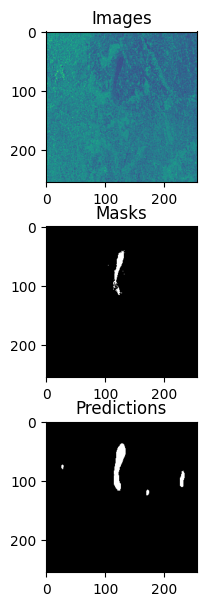

Dice Coefficient: 0.5861344337463379
Dice Coefficient Lackens: 0.009287925437092781


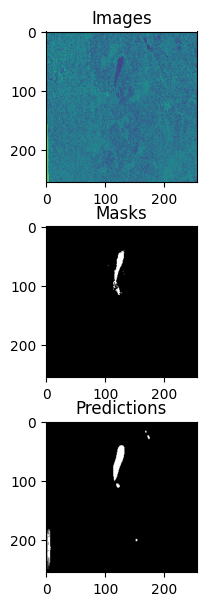

Dice Coefficient: 0.6678520441055298
Dice Coefficient Lackens: 0.011702127754688263


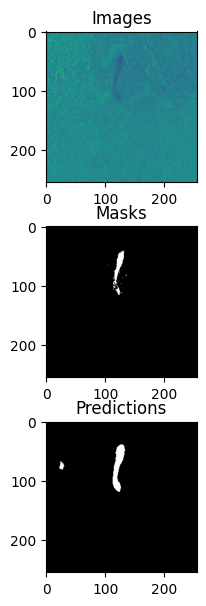

Dice Coefficient: 0.5871501564979553
Dice Coefficient Lackens: 0.0009099181042984128


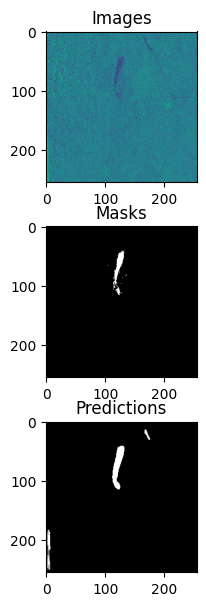

In [ ]:
for images, masks, lacken_masks in testloader:
    with torch.no_grad():

        pred = model(images.to(device)).detach()
        pred = (pred > 0.5).float()


    display_batch(images, masks, pred,lacken_masks)
